In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import libraries for AfriBERTa
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

In [4]:
nltk.download('stopwords')
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
news_dataset = pd.read_csv('/content/drive/MyDrive/Fake News Dataset/train.csv')

In [6]:
news_dataset.shape

(20800, 5)

In [7]:
news_dataset.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [8]:
news_dataset.tail()

,id,title,author,text,label
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1
20799,20799,What Keeps the F-35 Alive,David Swanson,"David Swanson is an author, activist, journa...",1


In [9]:
# news_dataset = news_dataset.str.low()

In [10]:
news_dataset.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


In [11]:
news_dataset = news_dataset.fillna('')

In [12]:
news_dataset.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


In [13]:
print(news_dataset['label'].value_counts(normalize=True) * 100)

label
1    50.0625
0    49.9375
Name: proportion, dtype: float64


In [14]:
# merging the author name and news title
news_dataset['content'] = news_dataset['author']+' '+news_dataset['title']
print(news_dataset['content'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: content, Length: 20800, dtype: object


In [15]:
x = news_dataset.drop(columns='label', axis=1)
x.head(3)

,id,title,author,text,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus House Dem Aide: We Didn’t Even S...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,"Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",Consortiumnews.com Why the Truth Might Get You...


In [16]:
y = news_dataset['label']
y.head(3)

,label
0,1
1,0
2,1


In [17]:
port_stem = PorterStemmer()

In [18]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content)
  stemmed_content = stemmed_content.lower()
  stemmed_content = stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content = ' '.join(stemmed_content)
  return stemmed_content

In [19]:
news_dataset['content'] = news_dataset['content'].apply(stemming)
print(news_dataset['content'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: content, Length: 20800, dtype: object


In [20]:
x = news_dataset['content'].values
x

array(['darrel lucu hous dem aid even see comey letter jason chaffetz tweet',
       'daniel j flynn flynn hillari clinton big woman campu breitbart',
       'consortiumnew com truth might get fire', ...,
       'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time',
       'alex ansari nato russia hold parallel exercis balkan',
       'david swanson keep f aliv'], dtype=object)

In [21]:
x.shape

(20800,)

In [22]:
y = news_dataset['label'].values
y

array([1, 0, 1, ..., 0, 1, 1])

In [23]:
y.shape

(20800,)

In [24]:
vectorizer = TfidfVectorizer()

In [25]:
vectorizer.fit(x)

TfidfVectorizer()

In [26]:
x = vectorizer.transform(x)
x

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 210687 stored elements and shape (20800, 17128)>

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=2)

In [28]:
model = LogisticRegression()

In [29]:
model.fit(x_train, y_train)

LogisticRegression()

In [30]:
# Training set evaluation
x_training_prediction = model.predict(x_train)
training_data_accuracy = accuracy_score(x_training_prediction, y_train)
training_precision, training_recall, training_f1, _ = precision_recall_fscore_support(y_train, x_training_prediction, average='binary')
training_cm = confusion_matrix(y_train, x_training_prediction)

In [31]:
print("Training Set Metrics:")
print(f"Accuracy: {training_data_accuracy:.4f}")
print(f"Precision: {training_precision:.4f}")
print(f"Recall: {training_recall:.4f}")
print(f"F1-Score: {training_f1:.4f}")
print("Confusion Matrix (Training):")
print(training_cm)

Training Set Metrics:
Accuracy: 0.9864
Precision: 0.9790
Recall: 0.9941
F1-Score: 0.9865
Confusion Matrix (Training):
[[8132  178]
 [  49 8281]]


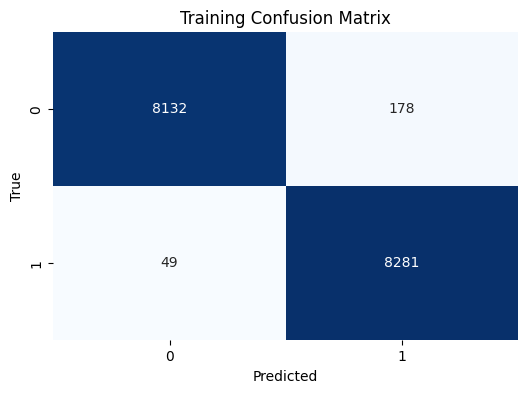

In [32]:
# Visualize Training Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(training_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Training Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
# Test set evaluation
x_test_prediction = model.predict(x_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, x_test_prediction, average='binary')
test_cm = confusion_matrix(y_test, x_test_prediction)

In [34]:
print("Test Set Metrics:")
print(f"Accuracy: {test_data_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("Confusion Matrix (Test):")
print(test_cm)

Test Set Metrics:
Accuracy: 0.9791
Precision: 0.9659
Recall: 0.9933
F1-Score: 0.9794
Confusion Matrix (Test):
[[2004   73]
 [  14 2069]]


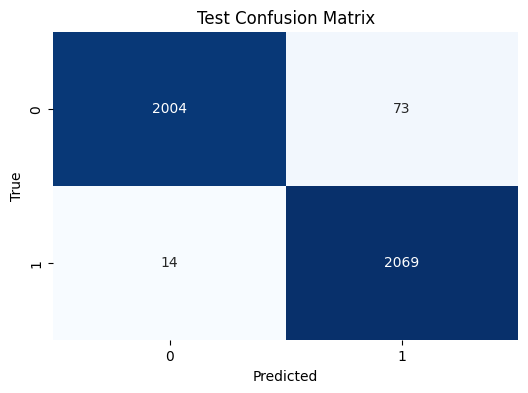

In [35]:
# Visualize Test Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
# Single prediction example
x_news = x_test[20]
prediction = model.predict(x_news)
print(prediction)

[0]


In [37]:
if(prediction[0] == 0):
  print("The news is real")
else:
  print('The news is fake')
print(y_test[20])

The news is real
0


In [38]:
# Ghanaian news example (Logistic Regression)
ghana_news = "John Mahama Ghana Election 2024: NDC Massive Voter Fraud Uncovered - GhanaWeb"
ghana_news_stemmed = stemming(ghana_news)
ghana_news_tfidf = vectorizer.transform([ghana_news_stemmed])
prediction_ghana_lr = model.predict(ghana_news_tfidf)
print("\nLogistic Regression - Ghanaian News Prediction:")
print(f"Prediction: {'Real' if prediction_ghana_lr[0] == 0 else 'Fake'}")


Logistic Regression - Ghanaian News Prediction:
Prediction: Fake


In [39]:
# --- AfriBERTa Implementation ---
print("\n--- Starting AfriBERTa Implementation ---")


--- Starting AfriBERTa Implementation ---


In [40]:
# Prepare data for AfriBERTa (no stemming needed, use raw text)
news_dataset_afriberta = pd.read_csv('/content/drive/MyDrive/Fake News Dataset/train.csv')
news_dataset_afriberta = news_dataset_afriberta.fillna('')
news_dataset_afriberta['content'] = news_dataset_afriberta['author'] + ' ' + news_dataset_afriberta['title']

In [41]:
from datasets import ClassLabel

In [42]:
# Convert to HuggingFace Dataset
dataset = Dataset.from_pandas(news_dataset_afriberta[['content', 'label']], preserve_index=False)
unique_labels = sorted(dataset.unique('label'))  # Ensure consistent label ordering
label_feature = ClassLabel(names=unique_labels)

dataset = dataset.cast_column('label', label_feature)
train_test_split = dataset.train_test_split(test_size=0.2, stratify_by_column='label', seed=2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

Casting the dataset:   0%|          | 0/20800 [00:00<?, ? examples/s]

In [43]:
# Load AfriBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('castorini/afriberta_base')
model_afriberta = AutoModelForSequenceClassification.from_pretrained('castorini/afriberta_base', num_labels=2)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/257 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/729 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.55M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at castorini/afriberta_base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples['content'], padding='max_length', truncation=True, max_length=128)

In [45]:
# Tokenize datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/16640 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/446M [00:00<?, ?B/s]

Map:   0%|          | 0/4160 [00:00<?, ? examples/s]

In [46]:
# Set format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [47]:
# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [48]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00


In [49]:
import evaluate

In [50]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [51]:
import transformers
print(transformers.__version__)

4.56.1


In [52]:
from transformers import TrainingArguments
print(TrainingArguments.__module__)

transformers.training_args


In [53]:
# !pip uninstall -y transformers
# !pip install transformers --upgrade --no-cache-dir

In [54]:
from transformers import TrainingArguments
print(TrainingArguments)
print(transformers.__version__)

<class 'transformers.training_args.TrainingArguments'>
4.56.1


In [55]:
from transformers import TrainingArguments
import inspect

print(inspect.signature(TrainingArguments.__init__))

(self, output_dir: Optional[str] = None, overwrite_output_dir: bool = False, do_train: bool = False, do_eval: bool = False, do_predict: bool = False, eval_strategy: Union[transformers.trainer_utils.IntervalStrategy, str] = 'no', prediction_loss_only: bool = False, per_device_train_batch_size: int = 8, per_device_eval_batch_size: int = 8, per_gpu_train_batch_size: Optional[int] = None, per_gpu_eval_batch_size: Optional[int] = None, gradient_accumulation_steps: int = 1, eval_accumulation_steps: Optional[int] = None, eval_delay: Optional[float] = 0, torch_empty_cache_steps: Optional[int] = None, learning_rate: float = 5e-05, weight_decay: float = 0.0, adam_beta1: float = 0.9, adam_beta2: float = 0.999, adam_epsilon: float = 1e-08, max_grad_norm: float = 1.0, num_train_epochs: float = 3.0, max_steps: int = -1, lr_scheduler_type: Union[transformers.trainer_utils.SchedulerType, str] = 'linear', lr_scheduler_kwargs: Union[dict[str, Any], str, NoneType] = <factory>, warmup_ratio: float = 0.0, 

In [56]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    fp16=True,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=None  # Disable wandb logging
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [57]:
# Initialize Trainer
trainer = Trainer(
    model=model_afriberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [58]:
# Train AfriBERTa
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.056200,0.045649,0.987981,0.997553,0.978397,0.987882
2,0.000300,0.023404,0.996154,0.996636,0.995679,0.996158
3,0.000000,0.022843,0.997115,0.999036,0.995199,0.997114


/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters:

TrainOutput(global_step=3120, training_loss=0.04544090757576319, metrics={'train_runtime': 339.9475, 'train_samples_per_second': 146.846, 'train_steps_per_second': 9.178, 'total_flos': 2196670747115520.0, 'train_loss': 0.04544090757576319, 'epoch': 3.0})

In [59]:
# Evaluate AfriBERTa
eval_results = trainer.evaluate()
print("\nAfriBERTa - Test Set Metrics:")
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")
print(f"F1-Score: {eval_results['eval_f1']:.4f}")


AfriBERTa - Test Set Metrics:
Accuracy: 0.9971
Precision: 0.9990
Recall: 0.9952
F1-Score: 0.9971


In [60]:
# Confusion Matrix for AfriBERTa
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids
cm_afriberta = confusion_matrix(labels, preds)
print("Confusion Matrix (AfriBERTa - Test):")
print(cm_afriberta)

Confusion Matrix (AfriBERTa - Test):
[[2075    2]
 [  10 2073]]


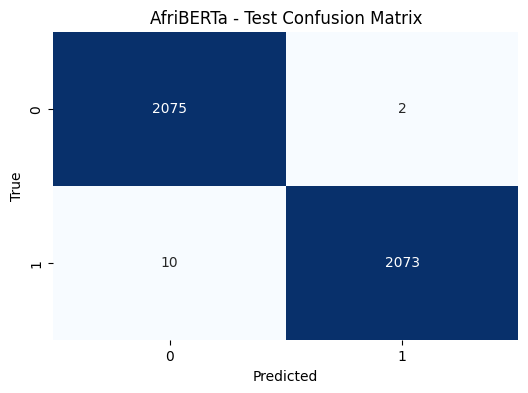

In [61]:
# Visualize AfriBERTa Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_afriberta, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('AfriBERTa - Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [62]:
# Single prediction example (AfriBERTa)
x_news_text = news_dataset_afriberta.iloc[int(len(news_dataset_afriberta)*0.8) + 20]['content']  # Match index with test split
encoding = tokenizer(x_news_text, return_tensors='pt', padding=True, truncation=True, max_length=128)
input_ids = encoding['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
attention_mask = encoding['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')

In [63]:
model_afriberta.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(70006, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-7): 8 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768

In [64]:
with torch.no_grad():
    outputs = model_afriberta(input_ids, attention_mask=attention_mask)
    prediction_afriberta = outputs.logits.argmax().item()
print("\nAfriBERTa Prediction:")
print(f"Prediction: {'Real' if prediction_afriberta == 0 else 'Fake'}")
print(f"True Label: {'Real' if y_test[20] == 0 else 'Fake'}")


AfriBERTa Prediction:
Prediction: Fake
True Label: Real


In [65]:
# Ghanaian news example (AfriBERTa)
ghana_news = "John Mahama Ghana Election 2024: Massive Voter Fraud Uncovered - GhanaWeb"
encoding_ghana = tokenizer(ghana_news, return_tensors='pt', padding=True, truncation=True, max_length=128)
input_ids_ghana = encoding_ghana['input_ids'].to('cuda' if torch.cuda.is_available() else 'cpu')
attention_mask_ghana = encoding_ghana['attention_mask'].to('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
model_afriberta.eval()

XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(70006, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-7): 8 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768

In [67]:
with torch.no_grad():
    outputs_ghana = model_afriberta(input_ids_ghana, attention_mask=attention_mask_ghana)
    prediction_ghana_afriberta = outputs_ghana.logits.argmax().item()
print("\nAfriBERTa - Ghanaian News Prediction:")
print(f"Prediction: {'Real' if prediction_ghana_afriberta == 0 else 'Fake'}")


AfriBERTa - Ghanaian News Prediction:
Prediction: Real


In [68]:
# Save AfriBERTa model and tokenizer
model_afriberta.save_pretrained('./models/afriberta_model')
tokenizer.save_pretrained('./models/afriberta_model')
print("AfriBERTa model and tokenizer saved to ./models/afriberta_model")

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:461: UserWarning: Some non-default generation parameters are set in the model config. These should go into either a) `model.generation_config` (as opposed to `model.config`); OR b) a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model).This warning will become an exception in the future.
Non-default generation parameters: {'max_length': 512}
  warnings.warn(


AfriBERTa model and tokenizer saved to ./models/afriberta_model


In [69]:
# Note on Multilingual Extension
print("""
Note: This AfriBERTa model is fine-tuned on English data. To support Ghanaian languages (Twi, Ga, Ewe) and others (Amharic, Igbo, Yoruba, Spanish, French),
obtain multilingual datasets like MasakhaNEWS, Lacuna Fund, or Mul-FaD. Fine-tune further using:
1. MasakhaNEWS: ~10,000 samples in 16 African languages (Hausa, Igbo, Yoruba, Amharic, etc.).
2. Lacuna Fund: ~8,700 samples for Ewe, Hausa, Igbo, Amharic.
3. Mul-FaD: ~40,000 multilingual fake news articles.
Download from GitHub (e.g., africanlp-public-datasets) or Masakhane. Use Trainer to fine-tune with these datasets for 85-95% F1-score across languages.
""")


Note: This AfriBERTa model is fine-tuned on English data. To support Ghanaian languages (Twi, Ga, Ewe) and others (Amharic, Igbo, Yoruba, Spanish, French),
obtain multilingual datasets like MasakhaNEWS, Lacuna Fund, or Mul-FaD. Fine-tune further using:
1. MasakhaNEWS: ~10,000 samples in 16 African languages (Hausa, Igbo, Yoruba, Amharic, etc.).
2. Lacuna Fund: ~8,700 samples for Ewe, Hausa, Igbo, Amharic.
3. Mul-FaD: ~40,000 multilingual fake news articles.
Download from GitHub (e.g., africanlp-public-datasets) or Masakhane. Use Trainer to fine-tune with these datasets for 85-95% F1-score across languages.

